# Propagate InterProScan annotation through clusters and the network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Create meta file with InterProScan results

InterProScan file column names

- Protein accession (e.g. P51587)
- Sequence MD5 digest (e.g. 14086411a2cdf1c4cba63020e1622579)
- Sequence length (e.g. 3418)
- Analysis (e.g. Pfam / PRINTS / Gene3D)
- Signature accession (e.g. PF09103 / G3DSA:2.40.50.140)
- Signature description (e.g. BRCA2 repeat profile)
- Start location
- Stop location
- Score - is the e-value (or score) of the match reported by member database method (e.g. 3.1E-52)
- Status - is the status of the match (T: true)
- Date - is the date of the run
- InterPro annotations - accession (e.g. IPR002093)
- InterPro annotations - description (e.g. BRCA2 repeat)
- GO annotations with their source(s), e.g. GO:0005515(InterPro)|GO:0006302(PANTHER)|GO:0007195(InterPro,PANTHER). This is an optional column; only displayed if the --goterms option is switched on
- Pathways annotations, e.g. REACT_71. This is an optional column; only displayed if the --pathways option is switched on

In [ ]:
file_interpro = "./interproscan5_analysis/predicted_proteins_results_interproscan-v5.69-101.0.tsv"
file_meta = "~/4_structural_clustering/foldseekCluster90_1E-5/foldseekCluster90_1E-5_meta.csv"
col_names = [
    "Protein Accession",
    "Sequence MD5 Digest",
    "Sequence Length",
    "Analysis",
    "Signature Accession",
    "Signature Description",
    "Start Location",
    "Stop Location",
    "Score",
    "Status",
    "Date",
    "InterPro Annotations Accession",
    "InterPro Annotations Description",
    "GO Annotations",
    "Pathways Annotations"
]
df_interpro = pd.read_csv(file_interpro, sep="\t", names=col_names, header=None, index_col=False)
df_meta = pd.read_csv(file_meta)

In [ ]:
df_interpro['filter'] = df_interpro['Protein Accession'] + "_" + df_interpro['Analysis']
df_interpro['length'] = df_interpro['Stop Location'] - df_interpro['Start Location'] + 1
df_interpro.sort_values(by=['length'], ascending=False, inplace=True)
df_interpro.drop_duplicates(subset='filter', keep='first', inplace=True)
df_interpro.drop(columns=['filter'], inplace=True)

In [ ]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    df = df_interpro[df_interpro["Analysis"] == analysis][["Protein Accession", "Signature Description", "InterPro Annotations Description", "GO Annotations", "Start Location", "Stop Location"]]
    df_meta = df_meta.merge(df, left_on="member_record_id", right_on="Protein Accession", how="left")
    df_meta.drop(columns=["Protein Accession"], inplace=True)
    df_meta.rename(columns={
        "Signature Description": f"{analysis}_description",
        "InterPro Annotations Description": f"{analysis}_interpro_description",
        "GO Annotations": f"{analysis}_GO",
        "Start Location": f"{analysis}_start",
        "Stop Location": f"{analysis}_stop"}, inplace=True)

df_meta.drop(columns=["Pfam_interpro_description", "SUPERFAMILY_interpro_description", "Gene3D_description"], inplace=True)
df_meta.rename(columns={"Pfam_description": "Pfam", "Gene3D_interpro_description": "Gene3D", "SUPERFAMILY_description": "SUPERFAMILY"}, inplace=True)

In [ ]:
# replace '-' with np.nan
df_meta.replace('-', np.nan, inplace=True)

In [ ]:
df_meta.drop(columns=["Gene3D_GO", "SUPERFAMILY_GO"], inplace=True)

In [ ]:
df_meta.to_csv("./foldseekCluster90_1E-5_meta_single_interproscan_tmp.csv", index=False)

## Step 2: Expand InterProScan annotation to other cluster members

### Create summary files

In [34]:
file_meta = "./foldseekCluster90_1E-5_meta_interproscan_tmp.csv"
file_stats = "~/4_structural_clustering/foldseekCluster90_1E-5/foldseekCluster90_1E-5_stats.csv"
file_foldseek = "~/6_network_analysis/foldseek_structure_reps_all_vs_all/foldseekCluster90_structure_reps_all_vs_all.tsv"

df_meta = pd.read_csv(file_meta)
df_stats = pd.read_csv(file_stats)
df_foldseek = pd.read_csv(file_foldseek, sep="\t")

In [ ]:
df_meta.fillna("-", inplace=True)

In [ ]:
# Create CSV files with the annotation summary of the clusters
# indicate the count of all annotations for each cluster

for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:
    
    df = pd.DataFrame(columns=['cluster_id', f'{analysis}', f'{analysis}_count'])

    for i, row in df_meta[df_meta[f'{analysis}'].notna()].iterrows():
        
        cluster_id = row['cluster_id']
        term = row[f'{analysis}']

        if term not in df[df['cluster_id'] == cluster_id][f'{analysis}'].values:
            new_row = pd.DataFrame([{
                'cluster_id': cluster_id,
                f'{analysis}': term,
                f'{analysis}_count': 1
            }])
            df = pd.concat([df, new_row], ignore_index=True)
        else:
            df.loc[(df['cluster_id'] == cluster_id) & (df[f'{analysis}'] == term), f'{analysis}_count'] += 1
        
        print(i, cluster_id, term)
    
    df.sort_values(by=['cluster_id', f'{analysis}_count'], ascending=[True, False], inplace=True)
    df = df_stats.merge(df, on='cluster_id')
    df.to_csv(f"./foldseekCluster90_1E-5_stats_{analysis}_summary.csv", index=False)

### Create a stats file

In [ ]:
# Create stats CSV file top annotation for each cluster and its ratio
# (portion of annotated records in the cluster that share the top annotation)

for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:
    
    file_summary = f"./foldseekCluster90_1E-5_stats_{analysis}_summary.csv"
    df_summary = pd.read_csv(file_summary)

    for index, row in df_stats.iterrows():
        
        cluster_id = row['cluster_id']
        
        df = df_summary[df_summary['cluster_id'] == cluster_id]
        
        cluster_size = df['cluster_size'].values[0]
        
        try:
            top_annotation = df[df[f'{analysis}'] != '-'][f'{analysis}'].values[0]
            top_annotation_count = df[df[f'{analysis}'] != '-'][f'{analysis}_count'].values[0]
        except IndexError:
            top_annotation = np.nan
            top_annotation_count = 0
        
        try:
            no_annotation_count = df[df[f'{analysis}'] == '-'][f'{analysis}_count'].values[0]
        except IndexError:
            no_annotation_count = 0

        top_annotation_ration = round(top_annotation_count / (cluster_size - no_annotation_count), 2)

        if pd.isnull(top_annotation):
            df_stats.loc[index, f'{analysis}_annotation_type'] = np.nan
            df_stats.loc[index, f'{analysis}_annotation'] = np.nan
            df_stats.loc[index, f'{analysis}_ratio'] = np.nan
        else:
            df_stats.loc[index, f'{analysis}_annotation_type'] = "cluster"
            df_stats.loc[index, f'{analysis}_annotation'] = top_annotation
            df_stats.loc[index, f'{analysis}_ratio'] = top_annotation_ration

        print(cluster_id, cluster_size, top_annotation, top_annotation_ration)

df_stats.to_csv("./foldseekCluster90_stats_interpro_annotation_tmp.csv", index=False)

In [ ]:
plt.figure(figsize=(3, 4))

sns.kdeplot(df_meta[df_meta['SUPERFAMILY_annotation_type'] == 'cluster'], x="SUPERFAMILY_annotation_probability",
            fill=False, clip=(0,1))

# X-axis label
plt.xlabel('Cluster annotation probability')

#plt.savefig('./figures/cluster_interpro_pfam_annotation_probability_kde.png', dpi=600, bbox_inches='tight')
#plt.savefig('./figures/cluster_interpro_pfam_annotation_probability_kde.svg', bbox_inches='tight', format='svg')

plt.show()

## Step 3: Expand annotation using network information

In [50]:
file_meta = "./foldseekCluster90_1E-5_meta_single_interproscan_tmp.csv"
file_stats = "./foldseekCluster90_1E-5_stats_single_interproscan_tmp.csv"
file_foldseek = "~/6_network_analysis/foldseek_structure_reps_all_vs_all/foldseekCluster90_structure_reps_all_vs_all.tsv"

df_meta = pd.read_csv(file_meta)
df_stats = pd.read_csv(file_stats)
df_foldseek = pd.read_csv(file_foldseek, sep="\t")

In [51]:
df_stats = df_stats.merge(df_meta[[
    'cluster_member',
    'Pfam',
    'Pfam_start',
    'Pfam_stop',
    'Gene3D',
    'Gene3D_start',
    'Gene3D_stop',
    'SUPERFAMILY',
    'SUPERFAMILY_start',
    'SUPERFAMILY_stop']], left_on='structure_representative', right_on='cluster_member', how='left')

df_stats.drop(columns=['cluster_member'], inplace=True)

In [52]:
# leave only df rows that have cluster_representative from df_stats in query column
df_foldseek = df_foldseek[df_foldseek["query"].isin(df_stats[df_stats["structure_representative_plddt"] > 50]["structure_representative"])]
df_foldseek = df_foldseek[df_foldseek["target"].isin(df_stats[df_stats["structure_representative_plddt"] > 50]["structure_representative"])]

# filter out non-significant hits
df_foldseek = df_foldseek[df_foldseek['evalue'] < 1e-3]

# filter out self hits
df_foldseek = df_foldseek[df_foldseek["query"] != df_foldseek["target"]]

In [53]:
# add top target annotations to the df_foldseek
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    df_foldseek = df_foldseek.merge(df_stats[['structure_representative',
                                              f'{analysis}',
                                              f'{analysis}_start',
                                              f'{analysis}_stop']], left_on='target', right_on='structure_representative')
    
    df_foldseek = df_foldseek.drop(columns=['structure_representative'])

    df_foldseek = df_foldseek.rename(columns={
        f'{analysis}': f'target_{analysis}_annotation',
        f'{analysis}_start': f'target_{analysis}_start',
        f'{analysis}_stop': f'target_{analysis}_stop'})

In [54]:
def calculate_overlap(tstart, tend, target_start, target_stop, overlap_threshold=0.9):
    '''
    Calculate the overlap between Foldseek target hit and InterProScan target annotation
    Should be used to filter out hits that do not overlap with the target annotation
    '''
    query_range = set(range(int(tstart), int(tend) + 1))
    target_range = set(range(int(target_start), int(target_stop) + 1))

    overlap = query_range.intersection(target_range)

    return len(overlap) >= (overlap_threshold * len(target_range))

### Update the stats file

In [ ]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    df_foldseek_analysis = df_foldseek.dropna(subset=[f'target_{analysis}_annotation'])
    df_foldseek_analysis = df_foldseek_analysis[df_foldseek_analysis.apply(lambda row: calculate_overlap(row['tstart'], row['tend'], row[f'target_{analysis}_start'], row[f'target_{analysis}_stop']), axis=1)]
    
    for index, row in df_stats.iterrows():

        cluster_id = row["cluster_id"]
        cluster_str_rep = row['structure_representative']
        description = row[f'{analysis}_annotation']

        if pd.isnull(description):
            
            df_foldseek_sub = df_foldseek_analysis[df_foldseek_analysis['query'] == cluster_str_rep]
            annotated_members = df_foldseek_sub[df_foldseek_sub[f'target_{analysis}_annotation'].notna()].shape[0]
            
            if annotated_members > 0:

                community_size = df_foldseek_sub.shape[0]
                top_members = df_foldseek_sub[f'target_{analysis}_annotation'].value_counts().values[0]
                top_description = df_foldseek_sub[f'target_{analysis}_annotation'].value_counts().index[0]
                top_ratio = round(top_members / annotated_members, 2)

                df_stats.loc[index, f'{analysis}_annotation_type'] = 'network'
                df_stats.loc[index, f'{analysis}_annotation'] = top_description
                df_stats.loc[index, f'{analysis}_ratio'] = top_ratio

        print(cluster_id, description)

In [56]:
df_stats['Pfam_annotation_type'].value_counts()

Pfam_annotation_type
cluster    5514
network     821
Name: count, dtype: int64

In [57]:
df_stats['Gene3D_annotation_type'].value_counts()

Gene3D_annotation_type
cluster    2023
network     496
Name: count, dtype: int64

In [58]:
df_stats['SUPERFAMILY_annotation_type'].value_counts()

SUPERFAMILY_annotation_type
cluster    2745
network     534
Name: count, dtype: int64

In [59]:
df_stats.drop(columns=[
    'Pfam',
    'Pfam_start',
    'Pfam_stop',
    'Gene3D',
    'Gene3D_start',
    'Gene3D_stop',
    'SUPERFAMILY',
    'SUPERFAMILY_start',
    'SUPERFAMILY_stop'
    ], inplace=True)

In [60]:
df_stats[df_stats['Pfam_annotation_type'] == 'network']['Pfam_ratio'].describe()

count    821.000000
mean       0.886005
std        0.204841
min        0.210000
25%        0.810000
50%        1.000000
75%        1.000000
max        1.000000
Name: Pfam_ratio, dtype: float64

In [61]:
df_stats.to_csv("./foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv", index=False)

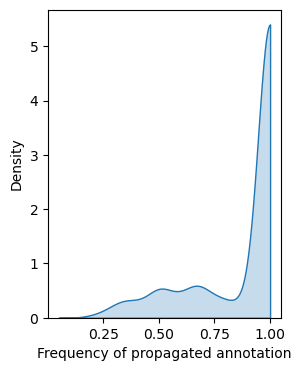

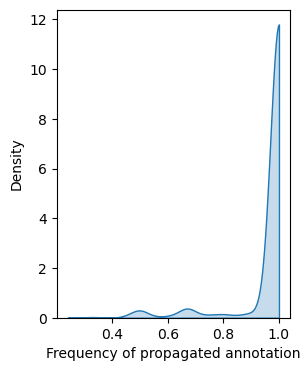

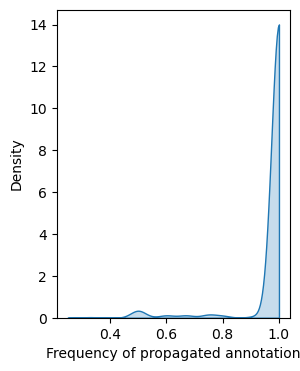

In [63]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    plt.figure(figsize=(3, 4))

    sns.kdeplot(df_stats[df_stats[f'{analysis}_annotation_type'] == 'network'][f'{analysis}_ratio'],
                fill=True, clip=(0,1))

    # X-axis label
    plt.xlabel('Frequency of propagated annotation')

    #plt.savefig('./figures/network_annotation_probability_kde.png', dpi=600, bbox_inches='tight')
    #plt.savefig('./figures/network_annotation_probability_kde.svg', bbox_inches='tight', format='svg')

    plt.show()

### Update the meta file with cluster info

In [ ]:
'''
Add functional annotation from the cluster expansion to the meta file
'''

for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    for index, row in df_meta.iterrows():
        
        cluster_id = row['cluster_id']
        cluster_rep = row['cluster_representative']
        description = row[f'{analysis}']

        if pd.isnull(description):
            
            top_description = df_stats[df_stats['cluster_representative'] == cluster_rep][f'{analysis}_annotation'].values[0]
            top_ratio = df_stats[df_stats['cluster_representative'] == cluster_rep][f'{analysis}_ratio'].values[0]
            
            if pd.isnull(top_description):
                df_meta.loc[index, f'{analysis}_annotation_type'] = np.nan
            else:
                df_meta.loc[index, f'{analysis}_annotation_type'] = "cluster"
            
            df_meta.loc[index, f'{analysis}_annotation'] = top_description
            df_meta.loc[index, f'{analysis}_ratio'] = top_ratio
                
        else:
            
            df_meta.loc[index, f'{analysis}_annotation_type'] = analysis
            df_meta.loc[index, f'{analysis}_annotation'] = description
            df_meta.loc[index, f'{analysis}_ratio'] = np.nan

        print(cluster_id, description)

In [68]:
df_meta.drop(columns=[
    'Pfam',
    'Pfam_GO',
    'Pfam_start',
    'Pfam_stop',
    'Gene3D',
    'Gene3D_start',
    'Gene3D_stop',
    'SUPERFAMILY',
    'SUPERFAMILY_start',
    'SUPERFAMILY_stop'
    ], inplace=True)

In [71]:
df_meta.to_csv("./foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv", index=False)

### Update the meta file with network info

In [ ]:
'''
Add functional annotation from the cluster expansion to the meta file
'''

for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:
    
    for index, row in df_stats[df_stats[f'{analysis}_annotation_type'] == 'network'].iterrows():
    
        cluster_id = row['cluster_id']
        cluster_rep = row['cluster_representative']
        
        annotation_type = row[f'{analysis}_annotation_type']
        annotation = row[f'{analysis}_annotation']
        annotation_probability = row[f'{analysis}_ratio']

        df_meta.loc[df_meta['cluster_representative'] == cluster_rep, f'{analysis}_annotation_type'] = annotation_type
        df_meta.loc[df_meta['cluster_representative'] == cluster_rep, f'{analysis}_annotation'] = annotation
        df_meta.loc[df_meta['cluster_representative'] == cluster_rep, f'{analysis}_ratio'] = annotation_probability

        print(cluster_id, annotation)

In [75]:
df_meta['SUPERFAMILY_annotation_type'].value_counts()

SUPERFAMILY_annotation_type
SUPERFAMILY    28431
cluster         5269
network         3845
Name: count, dtype: int64

In [76]:
df_meta.to_csv("./foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv", index=False)

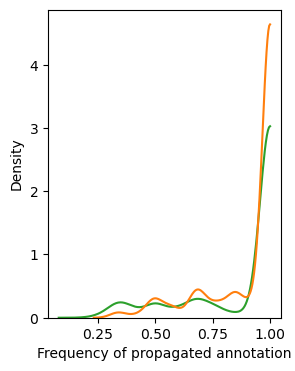

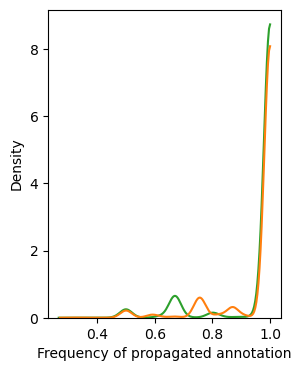

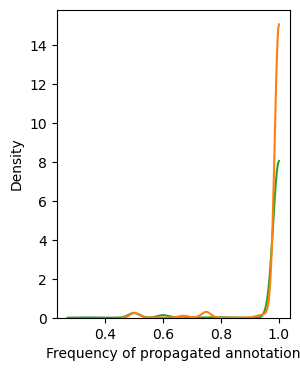

In [78]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    plt.figure(figsize=(3, 4))

    sns.kdeplot(df_meta, x=f"{analysis}_ratio", hue=f"{analysis}_annotation_type",
                fill=False, clip=(0,1), legend=False)

    # X-axis label
    plt.xlabel('Frequency of propagated annotation')

    #plt.savefig('./figures/network_annotation_probability_kde.png', dpi=600, bbox_inches='tight')
    #plt.savefig('./figures/network_annotation_probability_kde.svg', bbox_inches='tight', format='svg')

    plt.show()

## Step 4: Visualization of functional annotation expansion

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

### Frequency of propagated annotation

In [3]:
file_meta = "./foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv"
df_meta = pd.read_csv(file_meta)

In [4]:
file_stats = "./foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(file_stats)

In [20]:
df_stats[df_stats['Pfam_annotation_type'] == 'cluster']['Pfam_ratio'].describe()

count    5514.000000
mean        0.984193
std         0.075201
min         0.330000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Pfam_ratio, dtype: float64

- 5,514 clusters with Pfam annotation

In [22]:
df_stats[(df_stats['Pfam_annotation_type'] == 'cluster') &
         (df_stats['Pfam_ratio'] > 0.9)].shape[0]

5256

In [23]:
5256 / 5514

0.9532100108813928

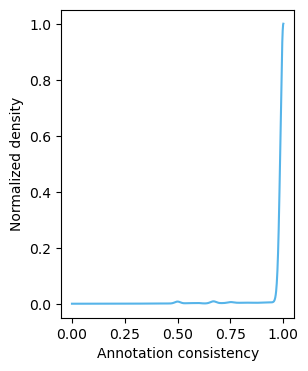

In [24]:
# Split the data based on'annotation_type
data1 = df_stats[df_stats['Pfam_annotation_type'] == 'cluster']['Pfam_ratio']

# Compute KDE
kde1 = gaussian_kde(data1)

# Create a range of values for the x-axis
x = np.linspace(0, 1, 1000)

# Compute the densities
density1 = kde1(x)

# Normalize the densities
density1 /= density1.max()

plt.figure(figsize=(3, 4))
plt.plot(x, density1, label='cluster', color='#56B4E9')
plt.xlabel('Annotation consistency')
plt.ylabel('Normalized density')
plt.savefig(f'./figures/functional_annotation/interpro_pfam_annotation_consistency_kde.svg', bbox_inches='tight', format='svg')
plt.show()

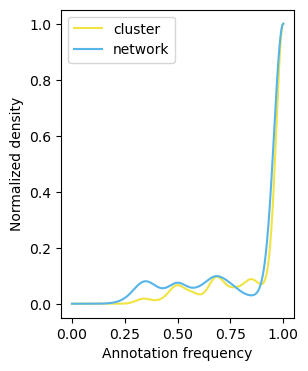

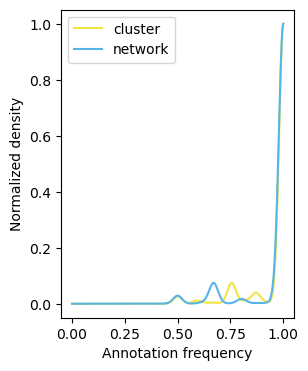

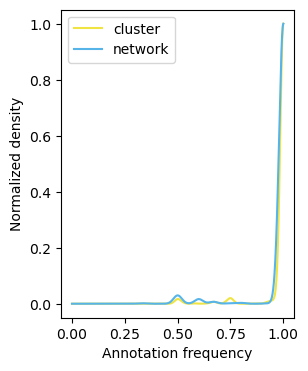

In [6]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:
#for analysis in ["Pfam"]:

    # Split the data based on'annotation_type
    data1 = df_meta[df_meta[f'{analysis}_annotation_type'] == 'cluster'][f'{analysis}_ratio']
    data2 = df_meta[df_meta[f'{analysis}_annotation_type'] == 'network'][f'{analysis}_ratio']

    # Compute KDE
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    # Create a range of values for the x-axis
    x = np.linspace(0, 1, 1000)

    # Compute the densities
    density1 = kde1(x)
    density2 = kde2(x)

    # Normalize the densities
    density1 /= density1.max()
    density2 /= density2.max()

    # Plot the normalized densities
    plt.figure(figsize=(3, 4))
    plt.plot(x, density1, label='cluster', color='#F0E442')
    plt.plot(x, density2, label='network', color='#56B4E9')
    plt.xlabel('Annotation frequency')
    plt.ylabel('Normalized density')
    plt.legend()
    plt.savefig(f'./figures/functional_annotation/interpro_{analysis}_propagated_annotation_frequency_kde.svg', bbox_inches='tight', format='svg')
    plt.show()

### Functional coverage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
file_meta = "./foldseekCluster90_1E-5_meta_single_interproscan_1E-3.csv"
df_meta = pd.read_csv(file_meta)

file_meta_go = "./foldseekCluster90_1E-5_meta_single_go_1E-3.csv" # can be created with gene_ontology_annnotation.ipynb
df_meta_go = pd.read_csv(file_meta_go)

file_stats = "./foldseekCluster90_1E-5_stats_single_interproscan_1E-3.csv"
df_stats = pd.read_csv(file_stats)

file_ictv = "~/1_dataset_preparation/msl38v2/VMR_MSL38_v2.xlsx"
df_ictv = pd.read_excel(file_ictv)

In [27]:
df_meta_go_sub = df_meta_go[[
    'cluster_member',
    'molecular_function_annotation_type',
    'molecular_function_annotation',
    'molecular_function_ratio',
    'biological_process_annotation_type',
    'biological_process_annotation',
    'biological_process_ratio',
    'cellular_component_annotation_type',
    'cellular_component_annotation',
    'cellular_component_ratio']]

In [28]:
df_meta = df_meta.merge(df_meta_go_sub, on='cluster_member', how='left')

In [29]:
# merge df_meta with df_stats[['cluster_representative', 'cluster_size']]
df_meta = df_meta.merge(df_stats[['cluster_representative', 'cluster_size']], on='cluster_representative', how='left')

In [30]:
for analysis in ["Pfam","Gene3D","SUPERFAMILY","molecular_function","biological_process","cellular_component"]:

    df_meta[f"{analysis}_annotation_type"] = df_meta.apply(
        lambda row: "singleton" if row["cluster_size"] == 1 and pd.isna(row[f"{analysis}_annotation_type"]) else row[f"{analysis}_annotation_type"],
        axis=1)

In [31]:
df_coverage = pd.DataFrame(columns=['analysis', 'total_count', 'analysis_count', 'cluster_count', 'network_count', 'singleton_count'])

for analysis in ["Pfam","SUPERFAMILY","Gene3D","molecular_function","biological_process","cellular_component"]:

    total_count = df_meta.shape[0]
    analysis_count = df_meta[df_meta[f"{analysis}_annotation_type"] == f'{analysis}'].shape[0]
    cluster_count = df_meta[df_meta[f"{analysis}_annotation_type"] == 'cluster'].shape[0]
    network_count = df_meta[df_meta[f"{analysis}_annotation_type"] == 'network'].shape[0]
    singleton_count = df_meta[df_meta[f"{analysis}_annotation_type"] == 'singleton'].shape[0]

    new_row = pd.DataFrame([{
        'analysis': analysis,
        'total_count': total_count,
        'analysis_count': analysis_count,
        'cluster_count': cluster_count,
        'network_count': network_count,
        'singleton_count': singleton_count
    }])

    df_coverage = pd.concat([df_coverage, new_row], ignore_index=True)

In [32]:
df_coverage

,analysis,total_count,analysis_count,cluster_count,network_count,singleton_count
0,Pfam,85162,55869,3395,2870,9441
1,SUPERFAMILY,85162,28431,5269,3845,10824
2,Gene3D,85162,22336,4475,4977,11185
3,molecular_function,85162,20892,2026,7262,11397
4,biological_process,85162,16141,1805,6060,11623
5,cellular_component,85162,8322,1276,2508,11923


In [33]:
df_coverage['analysis_percentage'] = df_coverage['analysis_count'] / df_coverage['total_count'] * 100
df_coverage['cluster_percentage'] = df_coverage['analysis_percentage'] + (df_coverage['cluster_count'] / df_coverage['total_count'] * 100)
df_coverage['network_percentage'] = df_coverage['cluster_percentage'] + (df_coverage['network_count'] / df_coverage['total_count'] * 100)
df_coverage['singleton_percentage'] = df_coverage['network_percentage'] + (df_coverage['singleton_count'] / df_coverage['total_count'] * 100)

<function matplotlib.pyplot.show(close=None, block=None)>

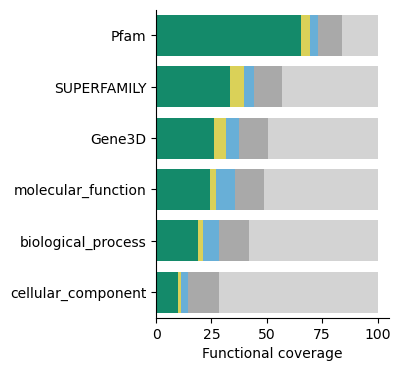

In [36]:
#for analysis in ["Pfam","Gene3D","SUPERFAMILY", "molecular_function", "biological_process", "cellular_component"]:

# change figure size
plt.figure(figsize=(3, 4))
sns.barplot(df_coverage, y="analysis", x=100, color='lightgrey', alpha=1)
sns.barplot(df_coverage, y="analysis", x=f"singleton_percentage", color='darkgrey', alpha=1)
sns.barplot(df_coverage, y="analysis", x=f"network_percentage", color='#56B4E9', alpha=1)
sns.barplot(df_coverage, y="analysis", x=f"cluster_percentage", color='#F0E442', alpha=1)
sns.barplot(df_coverage, y="analysis", x="analysis_percentage", color='#009E73', alpha=1)
# remove the top and right lines
sns.despine()
# remove the y-axis label
plt.ylabel("")
plt.xlabel("Functional coverage")
# save the figure
plt.savefig(f"./figures/functional_annotation/interpro_go_functional_coverage.svg", format="svg")
#plt.savefig(f"./figures/interpro_{analysis}_functional_coverage.png", format="png", dpi=600, bbox_inches='tight')
plt.show

### Functional coverage across realms

In [6]:
df_ictv_sub = df_ictv[["Sort", "Realm"]]
# add realm to df_coverage
df_meta = pd.merge(df_meta, df_ictv_sub, left_on="ictv_sort", right_on="Sort", how="left")
# replace Nan in realm with "Other"
df_meta["Realm"].fillna("Unclassified", inplace=True)
df_coverage = df_meta["Realm"].value_counts().reset_index()
# change the index order: Riboviria, Monodnaviria, Unclassified, Varidnaviria, Duplodnaviria, Ribozyviria
df_coverage = df_coverage.reindex([1, 4, 2, 0, 3, 5])
df_coverage

,Realm,count
1,Riboviria,22453
4,Monodnaviria,4551
2,Unclassified,21224
0,Varidnaviria,25265
3,Duplodnaviria,11653
5,Ribozyviria,16


In [7]:
for analysis in ["Pfam","Gene3D","SUPERFAMILY"]:

    df_coverage[f'{analysis}'] = df_coverage['Realm'].apply(lambda x: df_meta[(df_meta['Realm'] == x) & (df_meta[f'{analysis}_annotation_type'] == analysis)].shape[0])
    df_coverage[f'{analysis}_cluster'] = df_coverage['Realm'].apply(lambda x: df_meta[(df_meta['Realm'] == x) & (df_meta[f'{analysis}_annotation_type'] == 'cluster')].shape[0])
    df_coverage[f'{analysis}_network'] = df_coverage['Realm'].apply(lambda x: df_meta[(df_meta['Realm'] == x) & (df_meta[f'{analysis}_annotation_type'] == 'network')].shape[0])
    df_coverage[f'{analysis}_singleton'] = df_coverage['Realm'].apply(lambda x: df_meta[(df_meta['Realm'] == x) & (df_meta[f'{analysis}_annotation_type'] == 'singleton')].shape[0])

    df_coverage[f'{analysis}_percentage'] = round(df_coverage[analysis] / df_coverage['count'], 4) * 100
    df_coverage[f'{analysis}_cluster_percentage'] = df_coverage[f'{analysis}_percentage'] + round(df_coverage[f'{analysis}_cluster'] / df_coverage['count'], 4) * 100
    df_coverage[f'{analysis}_network_percentage'] = df_coverage[f'{analysis}_cluster_percentage'] + round(df_coverage[f'{analysis}_network'] / df_coverage['count'], 4) * 100
    df_coverage[f'{analysis}_singleton_percentage'] = df_coverage[f'{analysis}_network_percentage'] + round(df_coverage[f'{analysis}_singleton'] / df_coverage['count'], 4) * 100

In [8]:
df_coverage

,Realm,count,Pfam,Pfam_cluster,Pfam_network,Pfam_singleton,Pfam_percentage,Pfam_cluster_percentage,Pfam_network_percentage,Pfam_singleton_percentage,...,Gene3D_network_percentage,Gene3D_singleton_percentage,SUPERFAMILY,SUPERFAMILY_cluster,SUPERFAMILY_network,SUPERFAMILY_singleton,SUPERFAMILY_percentage,SUPERFAMILY_cluster_percentage,SUPERFAMILY_network_percentage,SUPERFAMILY_singleton_percentage
1,Riboviria,22453,18561,677,380,1212,82.67,85.69,87.38,92.78,...,63.58,70.51,11075,1698,1812,1511,49.33,56.89,64.96,71.69
4,Monodnaviria,4551,3472,261,189,303,76.29,82.03,86.18,92.84,...,65.54,72.94,2793,270,105,328,61.37,67.30,69.61,76.82
2,Unclassified,21224,10606,927,721,3465,49.97,54.34,57.74,74.07,...,17.70,36.57,4149,1174,641,3873,19.55,25.08,28.10,46.35
0,Varidnaviria,25265,15722,985,1202,2557,62.23,66.13,70.89,81.01,...,30.54,42.56,7484,1529,828,2909,29.62,35.67,38.95,50.46
3,Duplodnaviria,11653,7494,545,378,1902,64.31,68.99,72.23,88.55,...,26.10,45.40,2914,598,459,2203,25.01,30.14,34.08,52.99
5,Ribozyviria,16,14,0,0,2,87.50,87.50,87.50,100.00,...,93.75,100.00,16,0,0,0,100.00,100.00,100.00,100.00


85,162 records

- Pfam annotation: 65.6% (55,869 records)
- Pfam expansion with cluster: 3.99% (3,395 records)
- Pfam expansion with network: 3.37% (2,870 records)

- Gene3D annotation: 26.2% (22,336 records)
- Gene3D cluster: 5.25% (4,475 records)
- Gene3D network: 5.84% (4,977 records)

- Superfamily annotation: 33.4% (28,431 records)
- Superfamily cluster: 6.19% (5,269 records)
- Superfamily network: 4.51% (3,845 records)

In [28]:
#df_coverage['SUPERFAMILY_network'].sum() / df_coverage['count'].sum()
df_coverage['count'].sum()

85162

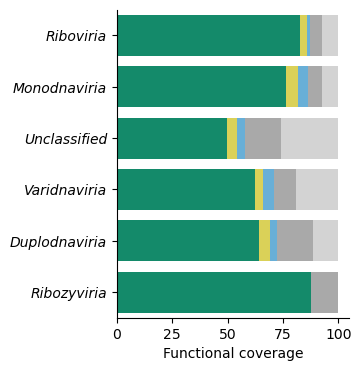

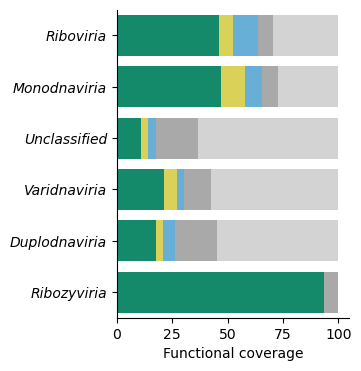

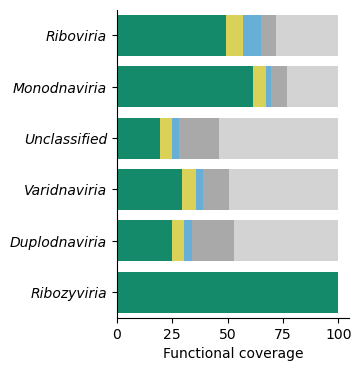

In [ ]:
for analysis in ["Pfam","Gene3D","SUPERFAMILY"]:

    # change figure size
    plt.figure(figsize=(3, 4))
    sns.barplot(df_coverage, y="Realm", x=100, color='lightgrey', alpha=1)
    sns.barplot(df_coverage, y="Realm", x=f"{analysis}_singleton_percentage", color='darkgrey', alpha=1)
    sns.barplot(df_coverage, y="Realm", x=f"{analysis}_network_percentage", color='#56B4E9', alpha=1)
    sns.barplot(df_coverage, y="Realm", x=f"{analysis}_cluster_percentage", color='#F0E442', alpha=1)
    sns.barplot(df_coverage, y="Realm", x=f"{analysis}_percentage", color='#009E73', alpha=1)
    # remove the top and right lines
    sns.despine()
    # remove the y-axis label
    plt.ylabel("")
    plt.xlabel("Functional coverage")
    # make y-tick labels italic
    plt.yticks(fontstyle='italic')
    # save the figure
    plt.savefig(f"./figures/functional_annotation/interpro_{analysis}_functional_coverage.svg", format="svg")
    #plt.savefig(f"./figures/interpro_{analysis}_functional_coverage.png", format="png", dpi=600, bbox_inches='tight')
    plt.show

## Create meta file with InterProScan results

InterProScan file column names

- Protein accession (e.g. P51587)
- Sequence MD5 digest (e.g. 14086411a2cdf1c4cba63020e1622579)
- Sequence length (e.g. 3418)
- Analysis (e.g. Pfam / PRINTS / Gene3D)
- Signature accession (e.g. PF09103 / G3DSA:2.40.50.140)
- Signature description (e.g. BRCA2 repeat profile)
- Start location
- Stop location
- Score - is the e-value (or score) of the match reported by member database method (e.g. 3.1E-52)
- Status - is the status of the match (T: true)
- Date - is the date of the run
- InterPro annotations - accession (e.g. IPR002093)
- InterPro annotations - description (e.g. BRCA2 repeat)
- GO annotations with their source(s), e.g. GO:0005515(InterPro)|GO:0006302(PANTHER)|GO:0007195(InterPro,PANTHER). This is an optional column; only displayed if the --goterms option is switched on
- Pathways annotations, e.g. REACT_71. This is an optional column; only displayed if the --pathways option is switched on

In [52]:
file_interpro = "./interproscan5_analysis/predicted_proteins_results_interproscan-v5.69-101.0.tsv"
file_meta = "~/4_structural_clustering/foldseekCluster90_1E-5/foldseekCluster90_1E-5_meta.csv"
col_names = [
    "Protein Accession",
    "Sequence MD5 Digest",
    "Sequence Length",
    "Analysis",
    "Signature Accession",
    "Signature Description",
    "Start Location",
    "Stop Location",
    "Score",
    "Status",
    "Date",
    "InterPro Annotations Accession",
    "InterPro Annotations Description",
    "GO Annotations",
    "Pathways Annotations"
]
df_interpro = pd.read_csv(file_interpro, sep="\t", names=col_names, header=None, index_col=False)
df_meta = pd.read_csv(file_meta)

In [53]:
df_interpro['filter'] = df_interpro['Protein Accession'] + "_" + df_interpro['Analysis']
df_interpro['length'] = df_interpro['Stop Location'] - df_interpro['Start Location'] + 1
df_interpro.sort_values(by=['length'], ascending=False, inplace=True)
df_interpro.drop_duplicates(subset='filter', keep='first', inplace=True)
df_interpro.drop(columns=['filter'], inplace=True)

In [54]:
for analysis in ["Pfam", "Gene3D", "SUPERFAMILY"]:

    df = df_interpro[df_interpro["Analysis"] == analysis][["Protein Accession", "Signature Description", "InterPro Annotations Description", "GO Annotations", "Start Location", "Stop Location"]]
    df_meta = df_meta.merge(df, left_on="member_record_id", right_on="Protein Accession", how="left")
    df_meta.drop(columns=["Protein Accession"], inplace=True)
    df_meta.rename(columns={
        "Signature Description": f"{analysis}_description",
        "InterPro Annotations Description": f"{analysis}_interpro_description",
        "GO Annotations": f"{analysis}_GO",
        "Start Location": f"{analysis}_start",
        "Stop Location": f"{analysis}_stop"}, inplace=True)

df_meta.drop(columns=["Pfam_interpro_description", "SUPERFAMILY_interpro_description", "Gene3D_description"], inplace=True)
df_meta.rename(columns={"Pfam_description": "Pfam", "Gene3D_interpro_description": "Gene3D", "SUPERFAMILY_description": "SUPERFAMILY"}, inplace=True)

In [55]:
# replace '-' with np.nan
df_meta.replace('-', np.nan, inplace=True)

In [56]:
df_meta.drop(columns=["Gene3D_GO", "SUPERFAMILY_GO"], inplace=True)

In [57]:
df_meta

,cluster_id,cluster_representative,structure_representative,cluster_member,clustering_method,member_class,member_record_id,protlen,plddt,ptm,...,Pfam,Pfam_GO,Pfam_start,Pfam_stop,Gene3D,Gene3D_start,Gene3D_stop,SUPERFAMILY,SUPERFAMILY_start,SUPERFAMILY_stop
0,1,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,CF-AAX47043.1.11_10545_relaxed,mmseq,CF,AAX47043.1.11_10545,462,96.4,0.94,...,Viral RNA-dependent RNA polymerase,GO:0003723(InterPro)|GO:0003968(InterPro)|GO:0...,27.0,438.0,Reverse transcriptase/Diguanylate cyclase domain,269.0,368.0,DNA/RNA polymerases,6.0,461.0
1,1,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,CF-ABK41188.1.11_10539_relaxed,mmseq,CF,ABK41188.1.11_10539,462,96.5,0.94,...,Viral RNA-dependent RNA polymerase,GO:0003723(InterPro)|GO:0003968(InterPro)|GO:0...,27.0,438.0,Reverse transcriptase/Diguanylate cyclase domain,269.0,368.0,DNA/RNA polymerases,8.0,461.0
2,1,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,CF-ACZ67658.1.11_10757_relaxed,mmseq,CF,ACZ67658.1.11_10757,460,95.7,0.93,...,Viral RNA-dependent RNA polymerase,GO:0003723(InterPro)|GO:0003968(InterPro)|GO:0...,27.0,431.0,Reverse transcriptase/Diguanylate cyclase domain,264.0,365.0,DNA/RNA polymerases,3.0,459.0
3,1,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,CF-AGH70290.1.11_10579_relaxed,mmseq,CF,AGH70290.1.11_10579,461,96.4,0.94,...,Viral RNA-dependent RNA polymerase,GO:0003723(InterPro)|GO:0003968(InterPro)|GO:0...,29.0,437.0,Reverse transcriptase/Diguanylate cyclase domain,268.0,367.0,DNA/RNA polymerases,1.0,461.0
4,1,CF-AKH10573.1.1.6_7109_relaxed,CF-BAA24003.1.11_10589_relaxed,CF-AFQ62099.1.1.10_10580_relaxed,mmseq,CF,AFQ62099.1.1.10_10580,453,96.1,0.94,...,Viral RNA-dependent RNA polymerase,GO:0003723(InterPro)|GO:0003968(InterPro)|GO:0...,29.0,429.0,Reverse transcriptase/Diguanylate cyclase domain,260.0,359.0,DNA/RNA polymerases,5.0,452.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85157,19063,CF-BAF45662.1_12759_relaxed,CF-BAF45662.1_12759_relaxed,CF-BAF45662.1_12759_relaxed,foldseek,CF,BAF45662.1_12759,128,94.0,0.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85158,19064,CF-BAF45663.1_12759_relaxed,CF-BAF45663.1_12759_relaxed,CF-BAF45663.1_12759_relaxed,foldseek,CF,BAF45663.1_12759,116,53.3,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85159,19065,CF-BAF45664.1_12759_relaxed,CF-BAF45664.1_12759_relaxed,CF-BAF45664.1_12759_relaxed,foldseek,CF,BAF45664.1_12759,159,79.7,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85160,19066,CF-BAF45668.1_12759_relaxed,CF-BAF45668.1_12759_relaxed,CF-BAF45668.1_12759_relaxed,foldseek,CF,BAF45668.1_12759,139,41.3,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_meta.to_csv("./foldseekCluster90_1E-5_meta_single_interproscan_tmp.csv", index=False)